# Example for Applying and Customizing Stainnorm

*Note*: This notebook assumes that `tiatoolbox` has already been installed. If it isn't, you can install it to your python environment by following guideline from https://github.com/TIA-Lab/tiatoolbox .

Welcome to tiatoolbox. This is an example on how to apply stain normalisation on image. We will 

1. Load up a sample whole slide image (WSI)
2. Extract a tile from the WSI
3. Stain-normalise the tile with various built-in method in the libraries
4. Extend the library to apply a custom stain-normalise method. 

With this, we will examine the `stainnorm` module of the library. We assume you are somewhat familiar with `wsireader` module, please check [here]() for their example usage if it's the otherwise.

We start by importing some related libraries.

In [2]:
import cv2
from tiatoolbox.dataloader.slide_info import slide_info
from tiatoolbox.dataloader import wsireader
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150 # for high resolution figure in notebook

Then, we will load a small WSI. This WSI is provided by the user via `user_sample_wsi_path`. By default, the value is `None` and the WSI will be downloaded with the web from the provided link instead. When downloading from the web, the WSI will be saved under `data_dir` with the named provided in `sample_file_name`. Additionally, data generated by the notebook will also be stored under `data_dir`. Users should change the `data_dir` to their preferred location.


In [3]:
data_dir = './'
sample_file_name = 'sample_wsi_small.svs'

user_sample_wsi_path = None

def download(url_path, save_path):
    r = requests.get(url_path)
    with open(save_path, "wb") as f:
        f.write(r.content)
    return

user_sample_wsi_path = None

if user_sample_wsi_path is None:
    sample_wsi_path = '%s/%s' % (data_dir, sample_file_name)
else:
    sample_wsi_path = user_sample_wsi_path
if not os.path.exists(sample_wsi_path):
    url_path = "http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs"
    download(url_path, sample_wsi_path)

Then we proceed to open the downloaded WSI sample with `OpenSlideWSIReader` and plot its thumbnail to check for region of interests. We also print out its basic information.


('objective_power', 20.0)
('slide_dimensions', (2220, 2967))
('level_count', 1)
('level_dimensions', ((2220, 2967),))
('level_downsamples', [1.0])
('vendor', 'aperio')
('mpp', (0.499, 0.499))
('file_path', PosixPath('sample_wsi_small.svs'))


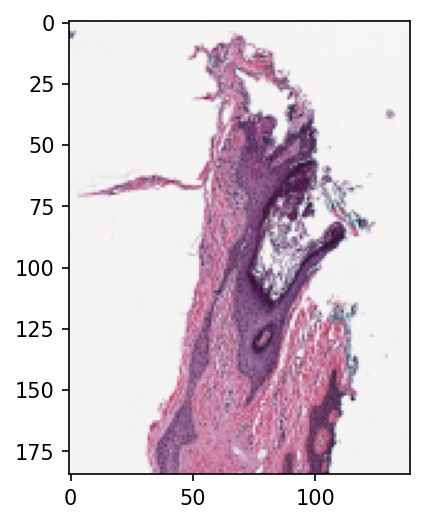

In [4]:
# create a file handler
wsi_reader = wsireader.OpenSlideWSIReader(
                input_path=sample_wsi_path)
wsi_info = wsi_reader.info.as_dict()
# we will print out each info line by line
print(*list(wsi_info.items()), sep='\n')
wsi_thumb = wsi_reader.get_thumbnail(resolution=1.25, units='power')

plt.imshow(wsi_thumb)
plt.show()


From the figure, around `50x50` at position `[50, 100]` (XY-coordinate) in the thumbnail contains both the stroma and the gland tissue component. This would be a nice sample for different staining method. The thumbnail is loaded at x1.25 objective power. We proceed to convert the position and size to `[800, 1600]` and `800x800` at x16 objective power and load the area up.

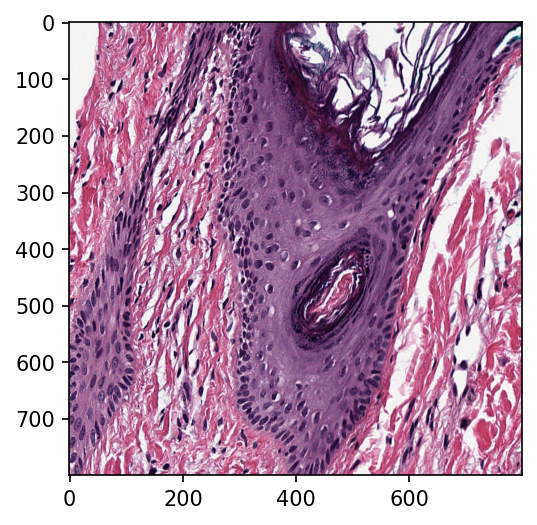

In [6]:
sample = wsi_reader.read_region(
            location=[800, 1600], # in X, Y
            level=0, size=[800, 800])
plt.imshow(sample)
plt.show()


Now we will download a different image to act as target stain.

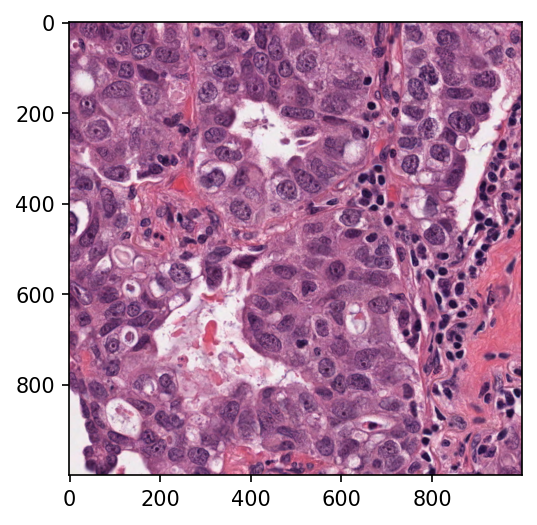

In [8]:
# downloading the target image
url_path = "https://raw.githubusercontent.com/TIA-Lab/tiatoolbox/develop/data/target_image.png"
target_image_path = '%s/stain_target.png' % (data_dir)
download(url_path, target_image_path)

target_image = cv2.imread(target_image_path)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
plt.imshow(target_image)
plt.show()

We then stain-normalise the `sample` image to the target image using the widely-known Vahadane method. The normaliser follow the `sklearn` calling style and is applied as follows:

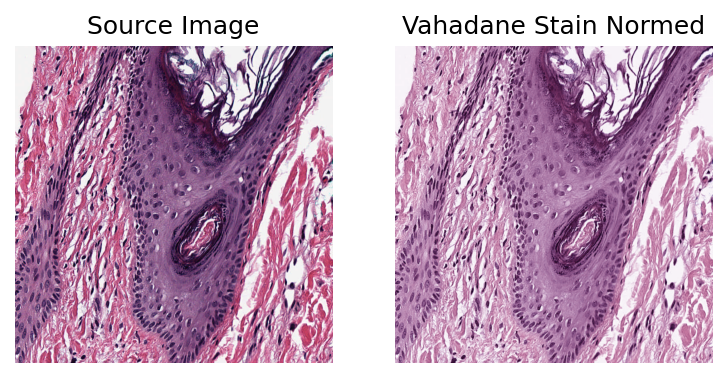

In [9]:
from tiatoolbox.tools import stainnorm

stain_normalizer = stainnorm.VahadaneNormaliser()
stain_normalizer.fit(target_image)

normed_sample = stain_normalizer.transform(sample.copy())

plt.subplot(1,2,1)
plt.imshow(sample)
plt.title('Source Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(normed_sample)
plt.title('Vahadane Stain Normed')
plt.axis('off')
plt.show()


At the moment, the library contains implementation for 4 stain-normalisation methods. You can either create them by using their class name like above, or via our provided getter function `get_normaliser` by inputting the corresponding method name. Here, we will illustrate how can you use the latter approach to get the normaliser. 

The stain normalisation names are provide in `method_name_list` variable below. We will sequentially applied each method on the `sample` image and plot them up for visual comparison.

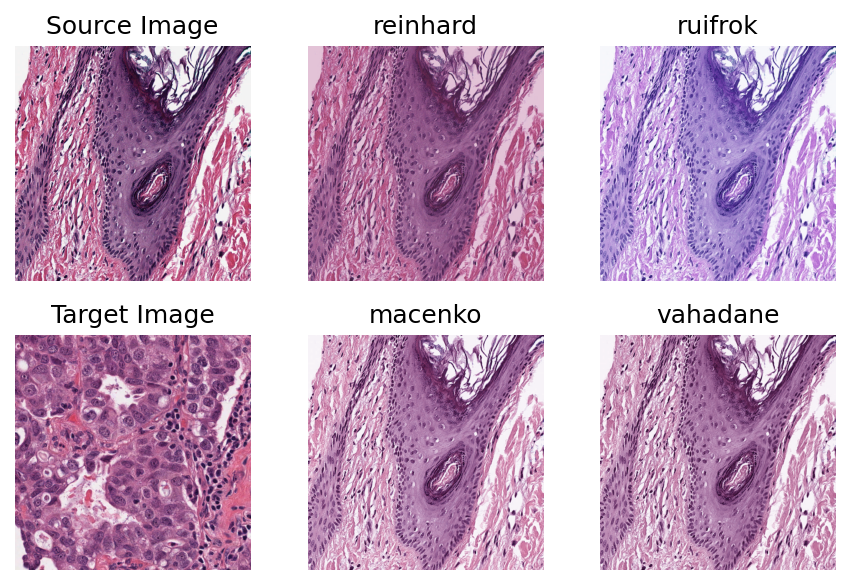

In [10]:
method_name_list = ['reinhard', 'ruifrok', 'macenko', 'vahadane']

plt.subplot(2,3,1)
plt.imshow(sample)
plt.title('Source Image')
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(target_image)
plt.title('Target Image')
plt.axis('off')

pos = [2, 3, 5, 6]
for idx, method_name in enumerate(method_name_list):
    stain_normalizer = stainnorm.get_normaliser(method_name)
    stain_normalizer.fit(target_image)

    normed_sample = stain_normalizer.transform(sample.copy())
    plt.subplot(2,3,pos[idx])
    plt.imshow(normed_sample)
    plt.title(method_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

Besides the 4 implemented methods, you can also extend the basic functionalities to create your own stain normalisation method. One way is to subclass the base class `stainnorm.StainNormaliser` and implement your method. The other way is to provide your custom stain conversion matrix and input it to the `stainnorm.StainNormaliser`. The former is for advance users only, we will only explore the latter case here. For illustration purpose, we will use the stain matrix in `skimage` library for getting Feulgen + Light Green stained from RGB. Finally, we compare the customly stain image with one from Vahadane.

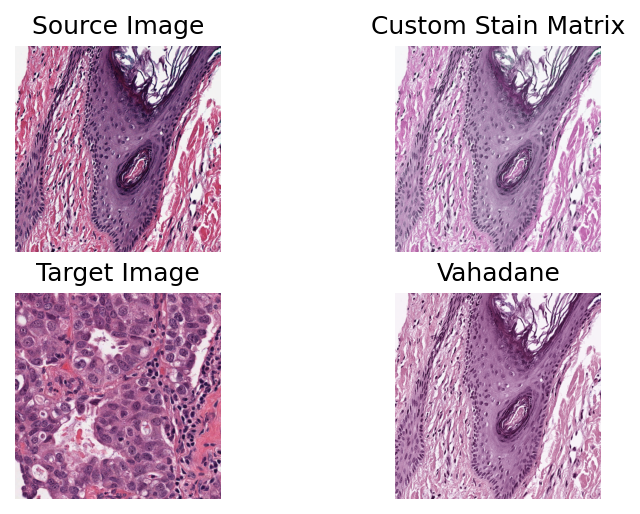

In [11]:

import skimage.color

stain_matrix = skimage.color.fgx_from_rgb[:2]
custom_normalizer = stainnorm.CustomNormaliser(stain_matrix)
custom_normalizer.fit(target_image)

vahadane_normalizer = stainnorm.VahadaneNormaliser()
vahadane_normalizer.fit(target_image)

normed_sample1 = custom_normalizer.transform(sample.copy())
normed_sample2 = stain_normalizer.transform(sample.copy())

plt.subplot(2,2,1)
plt.imshow(sample)
plt.title('Source Image')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(target_image)
plt.title('Target Image')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(normed_sample1)
plt.title('Custom Stain Matrix')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(normed_sample2)
plt.title('Vahadane')
plt.axis('off')
plt.show()